# Librerias 📚

In [26]:
import glob
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras

# IPNYB
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Obtain files 🗂️

In [27]:
files_MUM = glob.glob('translations/mu-/*.json')
files_MUP = glob.glob('translations/mu+/*.json')

# Code 💻

## Building X and y matrices

In [28]:
def reconstruct_matrix(data):
    # Declaration of a three-dimensional numpy matrix with two channels (side 1 and side 2) to give to a CNN.
    # The matrix will be filled with the energy deposited in each sparse coordinate (same coordinates as in the matrix).
    # The first channel is filled with the energy from the hits of the side 1 and the second channel is filled with the energy from hits of the side 2.
    
    for event, event_data in data.items():
        gruid_hits_side_1 = event_data['gruid hits - side 1']
        gruid_hits_side_2 = event_data['gruid hits - side 2']
        gruid_metadata = event_data['gruid metadata']
     
    matrix = np.zeros((gruid_metadata['# of rows (y)'], gruid_metadata['# of columns (x)'], 2))

    # IMPORTANT: Coordinates are inverted in the matrix because of matrix notation in GRUID.
    
    # Side 1
    for timestamp, timestamp_data in gruid_hits_side_1.items():
        for pixel, pixel_data in timestamp_data.items():
            x, y = pixel.split(",")
            matrix[ int(y), int(x), 0 ] = pixel_data['energy deposited']

    # Side 2
    for timestamp, timestamp_data in gruid_hits_side_2.items():
        for pixel, pixel_data in timestamp_data.items():
            x, y = pixel.split(",")
            matrix[ int(y), int(x), 1 ] = pixel_data['energy deposited']
        
    return matrix

muon_labels = np.ones(len(files_MUM))
antimuon_labels = np.zeros(len(files_MUP))
y = np.concatenate((muon_labels, antimuon_labels))

X = []
for file in files_MUM:
        with open(file) as f:
                data = json.load(f)
        X.append(reconstruct_matrix(data))
        
for file in files_MUP:
        with open(file) as f:
                data = json.load(f)
        X.append(reconstruct_matrix(data))
X = np.array(X)

In [29]:
X.shape, y.shape

((10167, 7, 5, 2), (10167,))

## Splitting the data

In [30]:
# Splitting the data into training and testing sets
# We will use 80% of the data for training and 20% of the data for testing.
# We will use the function train_test_split from sklearn.model_selection to split the data.
# We will use the parameter stratify to split the data in a stratified way.
# We will split the training data into training and validation sets.
# We will use 80% of the training data for training and 20% of the training data for validation.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6506, 7, 5, 2), (1627, 7, 5, 2), (2034, 7, 5, 2), (6506,), (1627,), (2034,))

In [31]:
# Making sure that the data is in the correct format for the CNN
# We will use the function reshape from numpy to reshape the data.
# We will reshape the data to have 4 dimensions. Parameter 1 will be the number of events, 2 and 3 will be the dimensions of the matrix and 4 will be the number of channels.
# Images are not square, so we will proportionally resize the images to be square.

# Dimensions to resize the images to
ROWS = 32
COLS = 32

X_train = np.array([keras.preprocessing.image.smart_resize(image, (ROWS, COLS)) for image in X_train])
X_val = np.array([keras.preprocessing.image.smart_resize(image, (ROWS, COLS)) for image in X_val])
X_test = np.array([keras.preprocessing.image.smart_resize(image, (ROWS, COLS)) for image in X_test])

# Reshaping the target data to have 2 dimensions (one-hot encoding)
#y_train = np.reshape(y_train, (-1, 1))
#y_val = np.reshape(y_val, (-1, 1))
#y_test = np.reshape(y_test, (-1, 1))

# Reshaping the target data to have 2 dimensions (one-hot encoding)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6506, 32, 32, 2),
 (1627, 32, 32, 2),
 (2034, 32, 32, 2),
 (6506, 2),
 (1627, 2),
 (2034, 2))

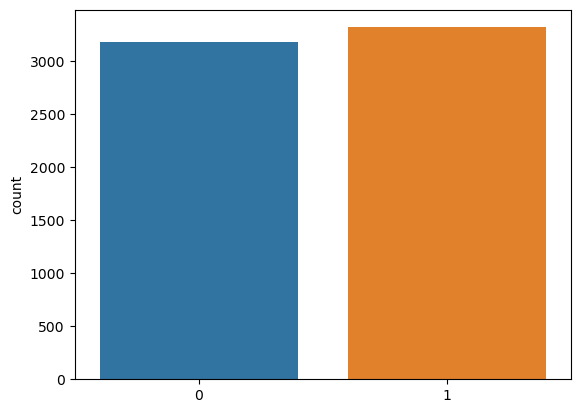

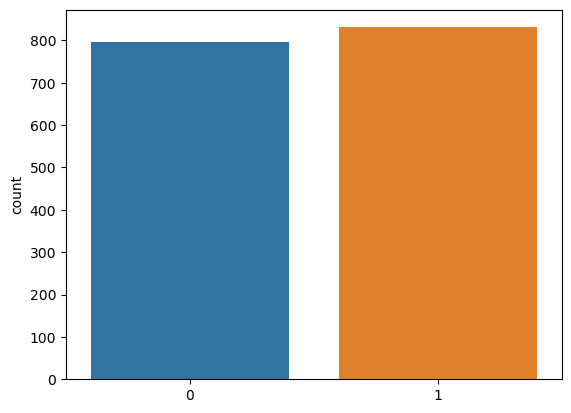

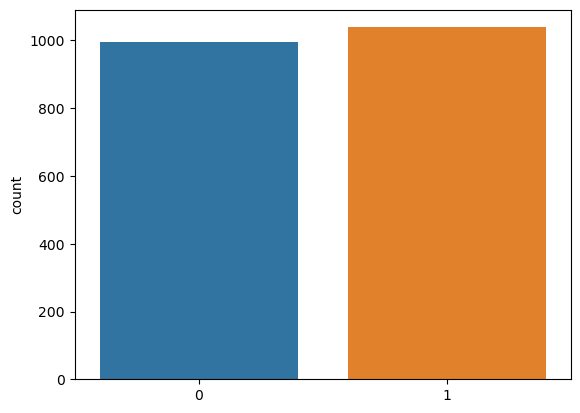

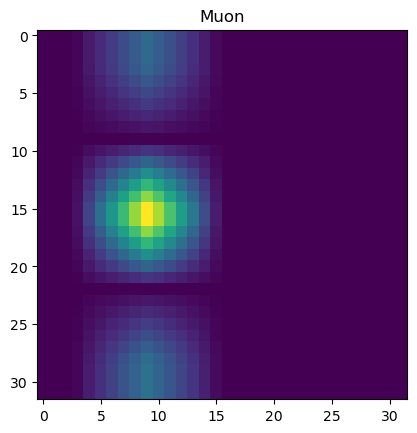

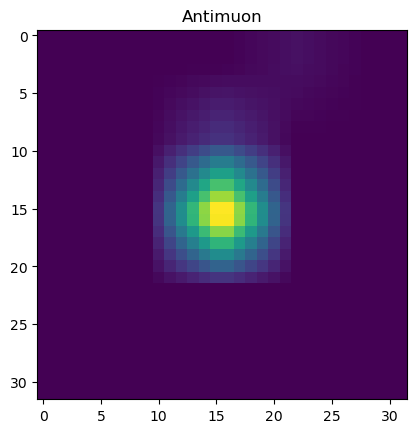

: 

In [35]:
# Testing the quality of the data
# We will use the function countplot from seaborn to plot the number of muons and antimuons in the training, validation and testing sets.
# We will use the function argmax from numpy to get the number of muons and antimuons in the training, validation and testing sets.

def plot_countplot(y):
    sns.countplot(x=np.argmax(y, axis=1))
    plt.show()

plot_countplot(y_train)
plot_countplot(y_val)
plot_countplot(y_test)

# Lets visualize the data
# We will use the function imshow from matplotlib.pyplot to visualize the data.

# Training set
plt.imshow(X_train[0, :, :, 0])
plt.title('Muon')
plt.show()

plt.imshow(X_train[1, :, :, 0])
plt.title('Antimuon')
plt.show()


## Convolutional Neural Network

In [32]:
# CNN
# We will use a CNN to classify the events.
# The input of the CNN will be a matrix with two channels (side 1 and side 2) with the energy deposited in each sparse coordinate.
# The output of the CNN will be a vector with two elements (one for each class).
# The CNN will have two convolutional layers, two max pooling layers and two dense layers.
# The first convolutional layer will have 32 filters and the second convolutional layer will have 64 filters.
# The first dense layer will have 64 neurons and the second dense layer will have 2 neurons (one for each class).
# The activation function of the first dense layer will be ReLU and the activation function of the second dense layer will be softmax.
# The loss function will be categorical crossentropy and the optimizer will be Adam.
# The metrics will be f1-score , precision, recall, AUC and accuracy.

def f1_score(precision, recall):
        return 2 * (precision * recall) / (precision + recall)

model = keras.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
        ])

# Compile the model and build F1 score metric
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[keras.metrics.Precision(), keras.metrics.Recall(),
                       keras.metrics.AUC(), keras.metrics.AUC(curve='ROC'), 'accuracy', f1_score])

model.summary()
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        608       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 2304)              0         
                                                                 
 dense_6 (Dense)             (None, 64)               

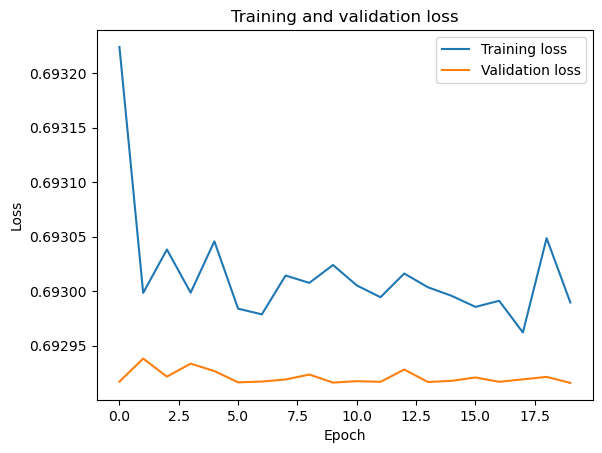

In [25]:
# Plotting the training and validation loss
# We will use the function plot from matplotlib.pyplot to plot the training and validation loss.
# We will use the function title from matplotlib.pyplot to add a title to the plot.
# We will use the function xlabel from matplotlib.pyplot to add a label to the x-axis.
# We will use the function ylabel from matplotlib.pyplot to add a label to the y-axis.
# We will use the function legend from matplotlib.pyplot to add a legend to the plot.

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
